<a href="https://colab.research.google.com/github/mehdimashayekhi/Generative-models/blob/main/NICE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A Simple Implementation of NICE (https://arxiv.org/abs/1410.8516)paper in Pytorch.
 

In [1]:
import torch
import torch.nn as nn
import numpy as np
from keras.datasets.mnist import load_data
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.distributions.uniform import Uniform
from torch.distributions.transforms import SigmoidTransform
from torch.distributions.transforms import AffineTransform

In [3]:
torch.manual_seed(0)

In [4]:
# load (and normalize) mnist dataset
(trainX, trainY), (testX, testy) = load_data()


11501568/11490434 [==============================] - 0s 0us/step


In [5]:
# dequantized version of the data
trainX = (np.float32(trainX) + torch.rand(trainX.shape).numpy()) / 255.
trainX = trainX.clip(0, 1)


In [6]:
trainX = torch.tensor(trainX.reshape(-1, 28 * 28))

In [7]:
class NICE(nn.Module):

    def __init__(self, data_dim=28 * 28, hidden_dim=1000):
        super().__init__()

        self.m = torch.nn.ModuleList([nn.Sequential(
            nn.Linear(data_dim // 2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, data_dim // 2), ) for i in range(4)])
        self.s = torch.nn.Parameter(torch.randn(data_dim))

    def forward(self, x):
        x = x.clone()
        for i in range(len(self.m)):
            x_i1 = x[:, ::2] if (i % 2) == 0 else x[:, 1::2]
            x_i2 = x[:, 1::2] if (i % 2) == 0 else x[:, ::2]
            h_i1 = x_i1
            h_i2 = x_i2 + self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = h_i1
            x[:, 1::2] = h_i2
        z = torch.exp(self.s) * x
        log_jacobian = torch.sum(self.s)
        return z, log_jacobian

    def invert(self, z):
        x = z.clone() / torch.exp(self.s)
        for i in range(len(self.m) - 1, -1, -1):
            h_i1 = x[:, ::2]
            h_i2 = x[:, 1::2]
            x_i1 = h_i1
            x_i2 = h_i2 - self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = x_i1 if (i % 2) == 0 else x_i2
            x[:, 1::2] = x_i2 if (i % 2) == 0 else x_i1
        return x

In [8]:
# Training
def training(normalizing_flow, optimizer, dataloader, distribution, nb_epochs=100, device='cpu'):
    training_loss = []
    for _ in tqdm(range(nb_epochs)):

        for batch in dataloader:
            z, log_jacobian = normalizing_flow(batch.to(device))
            log_likelihood = distribution.log_pdf(z) + log_jacobian
            loss = -log_likelihood.sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())

    return training_loss

In [9]:
class StandardLogisticDistribution:

    def __init__(self, data_dim=28 * 28, device='cpu'):
        self.m = TransformedDistribution(
            Uniform(torch.zeros(data_dim, device=device),
                    torch.ones(data_dim, device=device)),
            [SigmoidTransform().inv, AffineTransform(torch.zeros(data_dim, device=device),
                                                     torch.ones(data_dim, device=device))]
        )

    def log_pdf(self, z):
        return self.m.log_prob(z).sum(dim=1)

    def sample(self):
        return self.m.sample()


In [10]:
if torch.cuda.is_available():  
  device = "cuda" 
else:  
  device = "cpu"  
print(device)

cuda


In [11]:
normalizing_flow = NICE().to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=32, shuffle=True)


In [13]:
training_loss = training(normalizing_flow, optimizer, dataloader, logistic_distribution, nb_epochs=50,
                             device=device)

100%|██████████| 50/50 [45:45<00:00, 54.92s/it]


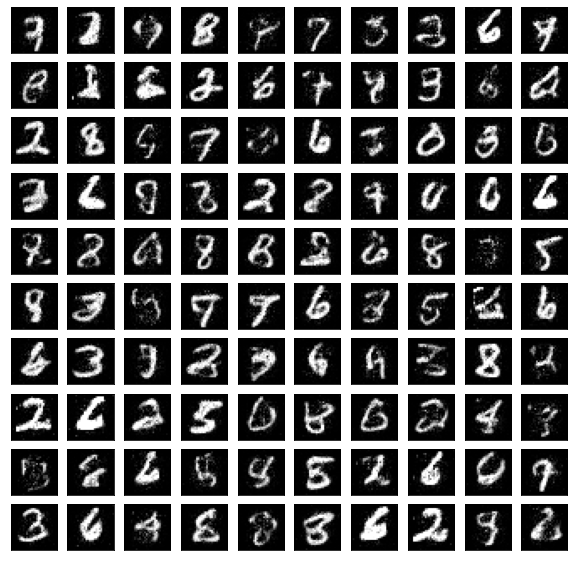

In [17]:
nb_data = 10
fig, axs = plt.subplots(nb_data, nb_data, figsize=(10, 10))
for i in range(nb_data):
    for j in range(nb_data):
        x = normalizing_flow.invert(logistic_distribution.sample().unsqueeze(0)).data.cpu().numpy()
        axs[i, j].imshow(x.reshape(28, 28).clip(0, 1), cmap='gray')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
# plt.savefig('Imgs/Generated_MNIST_data.png')
plt.show()

That was fun, if you want to gete better results, you can train it longer!!